In [3]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [4]:
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
            'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
target = 'income'

df = pd.read_csv('adult.data', sep=',', index_col=False, names=features + [target])

# Обзорный анализ выбранного датасета

In [5]:
display(df.head(3), df.shape)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


(32561, 15)

In [6]:
# Проврка пропусков
pd.DataFrame([df.isna().sum(), df.isnull().sum()], index={'na', 'null'})

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
na,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Проверка дубликатов
df.duplicated(keep=False).value_counts()

False    32514
True        47
dtype: int64

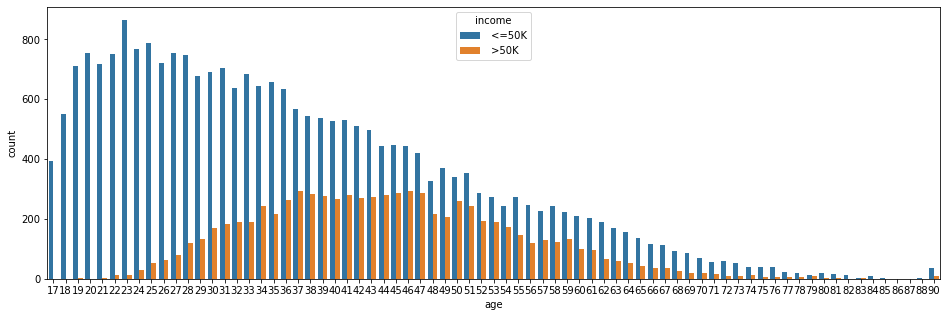

In [8]:
plt.figure(figsize=(16, 5))
sns.countplot(data=df, x='age', hue='income');

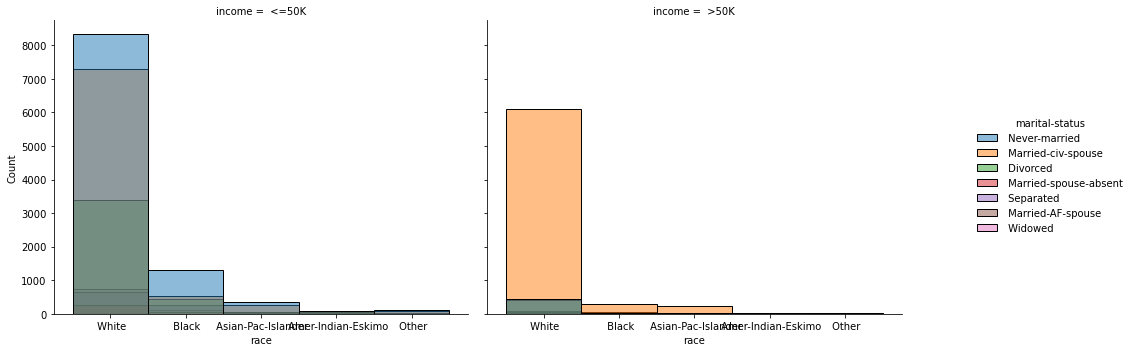

In [9]:
g = sns.displot(data=df, x="race", hue='marital-status', col='income', kind='hist')
g.fig.set_size_inches(16, 5)

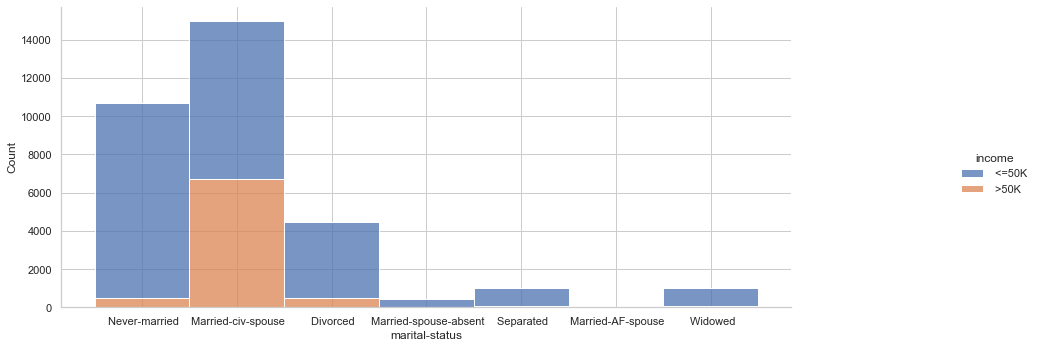

In [10]:
sns.set_theme(style="whitegrid")
b = sns.displot(data=df,
                x="marital-status",
                multiple='stack',
                hue='income')
b.fig.set_size_inches(16, 5)

In [ ]:
pip uninstall seaborn

In [22]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


# Cделать feature engineering

In [11]:
# Изменение целевой переменной
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})

In [16]:
from sklearn.model_selection import train_test_split

X = pd.get_dummies(df.drop('income', axis=1))
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Обучить любой классификатор (какой вам нравится)

In [17]:
%%time
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

[19:13:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 9.58 s


In [18]:
def evaluate_results(y_test, y_predict):
    """ Проверка качества модели с помощью DS-метрик"""
    from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

    return pd.DataFrame(
        [{
            'f1': f1_score(y_test, y_predict),
            'precision': precision_score(y_test, y_predict, average='binary'),
            'recall': recall_score(y_test, y_predict, average='binary'),
            'roc': roc_auc_score(y_test, y_predict),
        }],
        index={'metrics'}).round(3)


evaluate_results(y_test, y_predict)

,f1,precision,recall,roc
metrics,0.707,0.768,0.655,0.796


In [23]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [24]:
%%time

model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

Wall time: 42.4 s


# Всего тестового набора данных (summary_plot - дать интерпретацию)

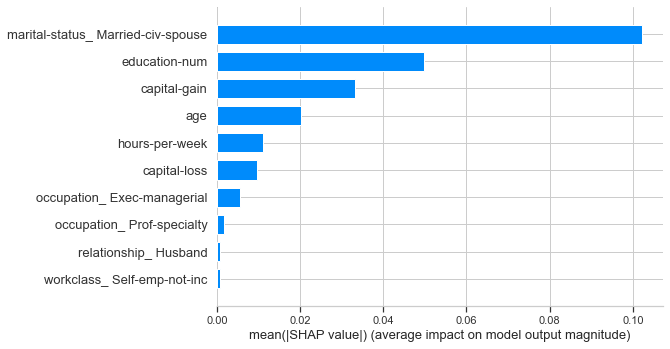

In [25]:
shap.summary_plot(shap_values=shap_values, features=X_train, plot_type='bar', max_display=10)

Наибольший вклад в вероятность получать высокий доход (> 50K \$ в год) вносит нахождение в браке, и только на 4 месте с больним отрывом - возраст.

для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [26]:
def force_plot(sample_number):
    display(
        pd.DataFrame(df.iloc[sample_number, :]).T,
        shap.force_plot(explainer.expected_value, shap_values[sample_number, :], X_train.iloc[sample_number, :]))

In [27]:
force_plot(sample_number=356)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
356,65,Private,161400,11th,7,Widowed,Other-service,Unmarried,Other,Male,0,0,40,United-States,0


Для человека под №356 наимблее важные признаки, чтобы получать боллее 50K \$ в год - (кроме семейного положения) - сколько часов в неделю работает и урочень образования